## Imports

In [199]:
import cv2
import os
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

## Settings

In [200]:
base_dir = '/home/drevital/obstacles_classification_datasets/black_belt'
in_dir = os.path.join(base_dir, 'single_no_mask')
imname = '238_obstacles_classification_11_2022-12-22T16-21-54_1.jpg' 
threshold = 55
belt_size = 40

## Read No Mask Image

In [201]:
impath = os.path.join(in_dir, imname)
no_mask = cv2.imread(impath)

## Create a Black Background with Margins ro Serve Later as a Belt

In [202]:
bg_h = no_mask.shape[0]
bg_w = no_mask.shape[1]//2
bg = np.zeros((bg_h + belt_size*2, bg_w + belt_size*2, 3), np.uint8)

## Generate <ref, current, mask> triplet from <ref, current> pair

In [203]:
w = no_mask.shape[1]
ref = no_mask[:, :w//2]
current = no_mask[:, w//2:]
xref = np.copy(bg)
xref[belt_size:belt_size+bg_h, belt_size:belt_size+bg_w] = ref
xcurrent = np.copy(bg)
xcurrent[belt_size:belt_size+bg_h, belt_size:belt_size+bg_w] = current

# Add ref and current on top of the black background, so they have a black belt at required size

diff = cv2.absdiff(xcurrent, xref)
agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
_, mask = cv2.threshold(agg_rgb, threshold, 255, cv2.THRESH_BINARY)

# old morphological operations
copyImg = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=1)  # reduce noise
copyImg = cv2.dilate(copyImg, np.ones((7, 7), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)
copyImg = cv2.dilate(copyImg, np.ones((9, 9), np.uint8), iterations=1)
kernel = np.ones((11, 11), np.uint8)  # kernel for dilation

# increase area to an object
copyImg = cv2.dilate(copyImg, kernel, iterations=2)
copyImg = cv2.dilate(copyImg, np.ones((13, 13), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((11, 11), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)

mask = copyImg 
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
mask = mask[belt_size:belt_size+bg_h, belt_size:belt_size+bg_w]

concat = cv2.hconcat([ref, current, mask])

## Store Image

In [204]:
out_dir = os.path.join(base_dir, 'compare')
Path(out_dir).mkdir(parents=True, exist_ok=True)
out_path = os.path.join(out_dir, 'belt_'+str(belt_size)+'.jpg')
cv2.imwrite(out_path, concat)

True

## Display Concatenated Image

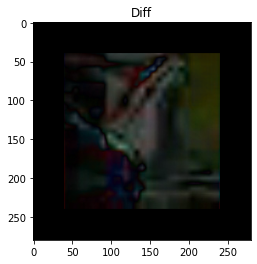

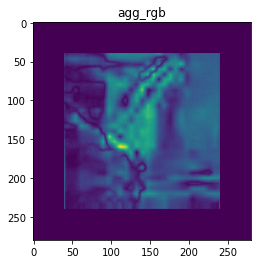

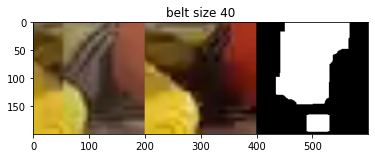

In [205]:
plt.imshow(diff)
plt.title('Diff')
plt.show()

plt.imshow(agg_rgb)
plt.title('agg_rgb')
plt.show()

concat = cv2.cvtColor(concat, cv2.COLOR_BGR2RGB)
plt.imshow(concat)
plt.title(f'belt size {belt_size}')
plt.show()